# Fitting exponential growth and R0 for Kenya

In this note I do two pieces of analysis:
* Fit a simple exponential growth model to the daily reported incidence in Kenya.
* Infer the $R_0$ value for Kenya by comparing the exponential growth rate to the moment generating function (MGF) of the generation time distribution.

This simple analysis was first performed on May 21st. Instead of updating the fit with the latest data, I demonstrate that the exponential growth rate posterior distribution using cases from 13th March to 21st May in now an underestimate.

In [1]:
using Plots,Distributions,ForwardDiff,Parameters,QuadGK,JLD2
using TransformVariables, LogDensityProblems, DynamicHMC, DynamicHMC.Diagnostics,Random

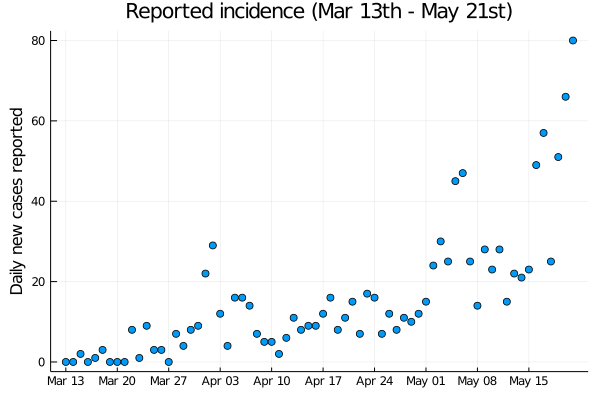

In [26]:
#Case data for Kenya - this is scraped from the background html generating this page https://www.worldometers.info/coronavirus/country/kenya/
case_dates = ["Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27","Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11","Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24","Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 02","Apr 03","Apr 04","Apr 05","Apr 06","Apr 07","Apr08",
 "Apr 09","Apr 10","Apr 11","Apr 12","Apr 13","Apr 14","Apr 15","Apr 16","Apr 17","Apr 18","Apr 19","Apr 20","Apr 21","Apr 22","Apr 23","Apr 24","Apr 25","Apr 26","Apr 27","Apr 28","Apr 29","Apr 30","May 01","May 02","May 03","May 04","May 05","May 06","May 07","May 08","May 09","May 10","May 11","May 12","May 13","May 14","May 15","May 16","May 17","May 18","May 19","May 20","May 21"]

new_cases = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,3,0,0,0,8,1,9,3,3,0,7,4,8,9,22,29,12,4,16,16,14,7,5,5,2,6,11,8,9,9,12,16,8,11,15,7,17,16,7,12,8,11,10,12,15,24,30,25,45,47,25,14,28,23,28,15,22,21,23,49,57,25,51,66,80]


#Shorten data to be from 13th March
f = findfirst(case_dates .== "Mar 13")
dates_str = case_dates[f:end]
cases = new_cases[f:end]

scatter(cases,lab = "",
    xticks = (1:7:length(dates_str),dates_str[1:7:end]),
    ylabel = "Daily new cases reported",
    title = "Reported incidence (Mar 13th - May 21st)")


The basic regression model is that the reported cases on each day $t$, $C_t$, are negative binomial distributed with an overdispersion parameter $\alpha$ and exponentially growing mean,
\begin{equation}
C_t \sim NegBin(\mu_t,\alpha), \\
\mu_t = c_0 \exp(rt).
\end{equation}
NB: The parameterisation of the negative binomial is related to the usually parameterisation $(p,r)$ thus:
\begin{equation}
 \sigma^2 = \mu + \alpha\mu^2, ~    p = 1 - ((\sigma^2 - \mu)/\sigma^2),~  r = \mu^2/(\sigma^2 - \mu).
\end{equation}
The three parameters of the model, $(r,\alpha,c_0)$, are jointly inferred using HMC.

In [30]:
#Struct containing case data 13th March to 21st May

@with_kw struct CaseData
    data
end
P = CaseData(data=cases)

#Callable function defining the log-likelihood function l(θ)

function (P::CaseData)(θ)
    @unpack r,c₀,α = θ
    @unpack data = P
    T = eltype(r) #∇l is calculated using Forward-mode automatic differentiation which replaces Floats with dual numbers. T is the detected type
    try  
        log_likelihood = 0.
        for t in 1:length(data)
            d = data[t]
            μ = c₀*exp(r*t)
            σ² = μ + α*μ^2
            p_negbin = 1 - (α*μ^2/σ²)
            r_negbin = 1/α
            log_likelihood += logpdf(NegativeBinomial(r_negbin,p_negbin),d)
        end
        return log_likelihood #Returns the log-likelihood
    catch
        return T(-Inf) #If the method fails because the sampler is trying an infeasible parameter (e.g. such that p is numerical zero) then this is interpreted as l = -∞
    end
end

#Define a parameter transformation which enforces non-nagativity for α and c₀.
trans = as((r = asℝ,α = asℝ₊,c₀ = asℝ₊))

ℓ = TransformedLogDensity(trans, P)#transformed log-likelihood
∇ℓ = LogDensityProblems.ADgradient(:ForwardDiff, ℓ)#transformed log-likelihood gradient wrt the parameters


ForwardDiff AD wrapper for TransformedLogDensity of dimension 3, w/ chunk size 3

In [46]:
#HMC routine
results = mcmc_with_warmup(Random.GLOBAL_RNG, ∇ℓ, 10000,
            initialization = (q = [0.1,log(3.),log(1.)], ));

┌ Info: finding initial optimum
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:71
┌ Info: found initial stepsize
│   ϵ = 0.00293
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:71
┌ Info: Starting MCMC
│   total_steps = 75
│   tuning = stepsize
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:102
┌ Info: MCMC progress
│   step = 1
│   seconds_per_step = 0.0041
│   estimated_seconds_left = 0.3
│   ϵ = 0.00293
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: Starting MCMC
│   total_steps = 25
│   tuning = stepsize and LinearAlgebra.Diagonal metric
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:102
┌ Info: MCMC progress
│   step = 1
│   seconds_per_step = 0.017
│   estimated_seconds_left = 0.41
│   ϵ = 0.00185
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: adaptation finished
│   adapted_kinetic_ene

┌ Info: MCMC progress
│   step = 1801
│   seconds_per_step = 0.0021
│   estimated_seconds_left = 18.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 1901
│   seconds_per_step = 0.0025
│   estimated_seconds_left = 20.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2001
│   seconds_per_step = 0.0025
│   estimated_seconds_left = 20.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2101
│   seconds_per_step = 0.0023
│   estimated_seconds_left = 18.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2201
│   seconds_per_step = 0.0022
│   estimated_seconds_left = 17.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 2301
│   seconds_per_step = 0.0023
│   estimated_seconds_

┌ Info: MCMC progress
│   step = 6401
│   seconds_per_step = 0.0024
│   estimated_seconds_left = 8.7
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6501
│   seconds_per_step = 0.002
│   estimated_seconds_left = 7.1
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6601
│   seconds_per_step = 0.0022
│   estimated_seconds_left = 7.5
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6701
│   seconds_per_step = 0.0025
│   estimated_seconds_left = 8.3
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6801
│   seconds_per_step = 0.0022
│   estimated_seconds_left = 7.0
└ @ DynamicHMC /Users/Sam/.julia/packages/DynamicHMC/83Q9C/src/reporting.jl:120
┌ Info: MCMC progress
│   step = 6901
│   seconds_per_step = 0.0021
│   estimated_seconds_left =

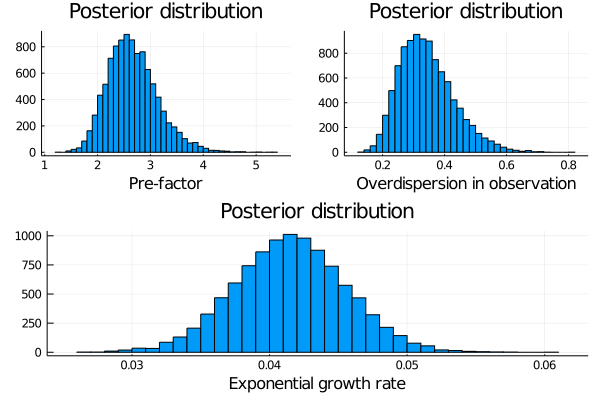

In [42]:
#Calculate and plot the marginal posterior distributions
posterior = transform.(trans, results.chain)
posterior_r = [θ.r for θ in posterior]
posterior_α = [θ.α for θ in posterior]
posterior_c₀ = [θ.c₀ for θ in posterior]

r_plt = histogram(posterior_r,bins = 50,lab = "",xlabel = "Exponential growth rate",title = "Posterior distribution" )
α_plt = histogram(posterior_α,bins = 50,lab = "",xlabel = "Overdispersion in observation",title = "Posterior distribution" )
c₀_plt = histogram(posterior_c₀,bins = 50,lab = "",xlabel = "Pre-factor",title = "Posterior distribution" )

layout = @layout [a b;c]
plt_posterior = plot(c₀_plt,α_plt,r_plt,layout = layout)

The conversion from $r$ to $R_0$ is based on the renewal equation, assuming no depletion in susceptibility at the early stage of the epidemic. We asssume that we can identify the average rate of creating secondary infections at time $\tau$ after a primary infection, $\beta(\tau)$. Then $R_0 = \int_0^\infty \beta(\tau) d\tau$ and the distribution of delay between primary and secondary infections (the *generation time distribution*) has pdf $w(\tau) = \beta(\tau)/R_0$. The rate of new incidence early in the epidemic follows,
\begin{equation}
 \iota(t) = \int_{0}^\infty \iota(t - \tau) \beta(\tau) ds.
\end{equation}
The exponential growth ansatz, $\iota(t) = \iota_0 e^{rt}$ implies,
\begin{equation}
1 = R_0\int_{0}^\infty  e^{-r\tau}w(\tau) ds \implies R_0 = 1/M_w(-r).
\end{equation}
Where $M_w(-r)$ is the MGF of the generation time distribution evaluated at the negative exponential growth rate. We can use the best fit generation distribution found in *Ferretti, L. et al. Quantifying SARS-CoV-2 transmission suggests epidemic control with digital contact tracing. Science (2020)* which was a Weibull distribution.

Is the real-time growth rate inferred from the fit to **reported** cases the same as the real-time growth rate for the renewal equation? This depends on the reporting rate and reporting delay being stationary in time. 

To see this, suppose that each true infection has probability $p$ of eventually being reported, and if reported a delay between infection and report with (stationary) pdf $\rho(t)$. Then the **reported** incidence $\hat{\iota}$ at the early stage of the epidemic follows,
\begin{equation}
\hat{\iota}(t) = p\int_0^\infty \iota(t-s) \rho(s) ds = p\iota_0 e^{rt} M_\rho(-r) = c_0 e^{rt}.
\end{equation}
Where $c_0 = p\iota_0 M_\rho(-r)$ is not time-varying.

However, if the reporting rate and/or reporting delay get typically shorter over time then even if $r$ remains constant in time it will appear to be increasing because $c_0$ will be increasing in time.

In [38]:
#The Weibull distribution doesn't have a simple closed form MGF therefore I solve for the MGF at -r numerically
tilted_weibull(t,r,α,θ) = exp(-r*t)*pdf(Weibull(α,θ),t)
function mgf_weibull(r)
    f = t -> tilted_weibull(t,r,2.826,5.665)#Ferretti best fit model
    quadgk(f,0,90.)[1]#Numerical quadrature
end

mgf_weibull (generic function with 1 method)

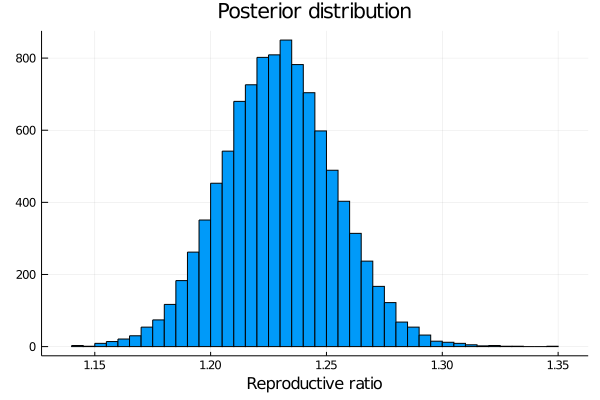

In [43]:
posterior_R₀ = [1/mgf_weibull(r) for r in posterior_r] 
R₀_plt = histogram(posterior_R₀,bins = 50,lab = "",xlabel = "Reproductive ratio",title = "Posterior distribution" )


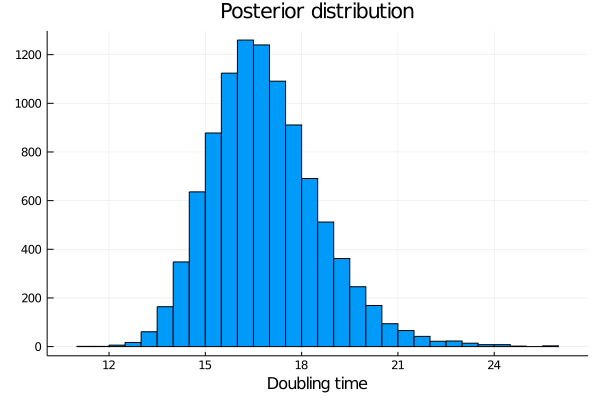

In [44]:
posterior_doubling_time = [log(2)/r for r in posterior_r]
doubling_time_plt = histogram(posterior_doubling_time,bins = 50,lab = "",xlabel = "Doubling time",title = "Posterior distribution" )

### Recent projection
I've bookended the notebook with a look at how the prediction has "aged" over the last couple of weeks. Unfortunately, I think that the growth rate is accelerating compared to where it was on the 21st May.

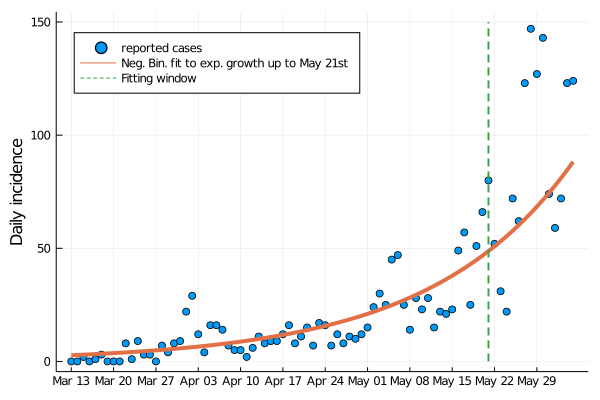

In [35]:
new_dates_str = ["Feb 15","Feb 16","Feb 17","Feb 18","Feb 19","Feb 20","Feb 21","Feb 22","Feb 23","Feb 24","Feb 25","Feb 26","Feb 27",
                "Feb 28","Feb 29","Mar 01","Mar 02","Mar 03","Mar 04","Mar 05","Mar 06","Mar 07","Mar 08","Mar 09","Mar 10","Mar 11",
                "Mar 12","Mar 13","Mar 14","Mar 15","Mar 16","Mar 17","Mar 18","Mar 19","Mar 20","Mar 21","Mar 22","Mar 23","Mar 24",
                "Mar 25","Mar 26","Mar 27","Mar 28","Mar 29","Mar 30","Mar 31","Apr 01","Apr 02","Apr 03","Apr 04","Apr 05","Apr 06",
                "Apr 07","Apr 08","Apr 09","Apr 10","Apr 11","Apr 12","Apr 13","Apr 14","Apr 15","Apr 16","Apr 17","Apr 18","Apr 19",
                "Apr 20","Apr 21","Apr 22","Apr 23","Apr 24","Apr 25","Apr 26","Apr 27","Apr 28","Apr 29","Apr 30","May 01","May 02",
                "May 03","May 04","May 05","May 06","May 07","May 08","May 09","May 10","May 11","May 12","May 13","May 14","May 15",
                "May 16","May 17","May 18","May 19","May 20","May 21","May 22","May 23","May 24","May 25","May 26","May 27","May 28",
                "May 29","May 30","May 31","Jun 01","Jun 02","Jun 03","Jun 04"]  
new_dates_str = new_dates_str[f:end]

new_incidence = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,3,0,0,0,8,
                    1,9,3,3,0,7,4,8,9,22,29,12,4,16,16,14,7,5,5,2,6,11,8,9,9,12,16,8,11,15,7,17,16,7,12,8,11,10,12,15,24,30,25,45,47,25,14,28,23,28,15,22,21,23,49,57,25,51,66,
                    80,52,31,22,72,62,123,147,127,143,74,59,72,123,124] 
new_incidence = new_incidence[f:end]

poserior_incidence = [ mean([posterior_c₀[i]*exp(posterior_r[i]*t) for i = 1:length(posterior_r)]) for t = 1:length(new_dates_str)]

plt_exp_growth_fit = scatter(1:length(new_dates_str),new_incidence,lab = "reported cases",legend = :topleft,
    xticks = (1:7:length(new_dates_str),new_dates_str[1:7:end]),
    ylabel = "Daily incidence")
plot!(plt_exp_growth_fit,poserior_incidence,lw=4,lab = "Neg. Bin. fit to exp. growth up to May 21st")
plot!([findfirst(new_dates_str .== "May 21"),findfirst(new_dates_str .== "May 21")],[0,150],
        lw = 2, ls = :dash,lab="Fitting window")

